In [1]:
# import os
# os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "expandable_segments:True"
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.models as models
from torchvision.models import alexnet
import torchvision.transforms as transforms

import math
from tqdm import tqdm
import numpy as np
import matplotlib.pyplot as plt

import time

In [3]:
# --- Core Computational Utilities ---

def compute_spectral_norm(matrix):
    """
    Computes the spectral norm of a matrix.
    """
    
    return torch.linalg.matrix_norm(matrix, ord=2)

In [4]:
def compute_l21_norm(matrix):
    """
    Computes the L(2,1) norm of a matrix: L2 norm of columns, then L1 of the result.
    """
    return torch.sum(torch.linalg.norm(matrix, ord=2, dim=0))

In [5]:
# --- Main Calculation Engine ---

def compute_spectral_complexity(model: nn.Module):
    """
    Computes the spectral complexity R_A for a given PyTorch model.
    """
    product_terms = list()
    summation_terms = list()
    
    device = next(model.parameters()).device

    max_layer_time = 0
    for name, module in model.named_modules():
        if isinstance(module, (nn.Conv2d, nn.Linear)):
            print(f"Processing layer: {name} of type {type(module).__name__}")

            A_i = module.weight.data
            rho_i = 1.0  # Lipschitz constant for ReLU is 1
            
            start_time = time.perf_counter()

            if A_i.dim() == 4:
                A_i = A_i.view(A_i.size(0), -1)
            
            # 1. Compute spectral norm and product term
            s_i = compute_spectral_norm(A_i)
            
            
            
            # 2. Construct the reference matrix M_i
            M_i = torch.zeros_like(A_i)
            
            # 3. Compute the deviation term for the summation
            # Formula requires ||A_i^T - M_i^T||_{2,1}
            deviation_matrix_T = A_i.T - M_i.T
            deviation_norm = compute_l21_norm(deviation_matrix_T)
            

            # Add a small epsilon to avoid division by zero if spectral norm is 0
            # sum_term = (deviation_norm**(2/3)) / ((s_i + 1e-12)**(2/3))
            sum_term = (deviation_norm / s_i)**(2/3)
            end_time = time.perf_counter()

            max_layer_time = max(max_layer_time, end_time - start_time)
            # sum_term = (deviation_norm / s_i)**(2/3)
            summation_terms.append(sum_term)
            product_terms.append(rho_i * s_i)

    # Calculate the final components
    # Product term: prod(rho_i * ||A_i||_sigma)
    total_product = torch.prod(torch.stack(product_terms))
    
    # Summation term: (sum(...))^(3/2)
    total_sum = torch.sum(torch.stack(summation_terms))
    final_sum_term = total_sum**(3/2)
    
    # Final Spectral Complexity R_A
    R_A = total_product * final_sum_term

    print(f"Maximum Computation Time for Layer: {max_layer_time:.4f}s")
    
    return R_A, total_product, final_sum_term

In [6]:
def compute_gamma_distribution(model_path, train = False):
    print("Loading pretrained AlexNet model...")
    
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model = Cifar10AlexNet().to(device)
    
    model.load_state_dict(torch.load(model_path, map_location=torch.device(device)))
        
    # Set the model to evaluation mode
    model.eval()
        
    # Compute the spectral complexity
    print("\nComputing spectral complexity...")
    start_time = time.perf_counter()
    spectral_complexity, product_component, sum_component = compute_spectral_complexity(model)
    end_time = time.perf_counter()
    print(f"Total Computation Time: {end_time - start_time:.4f}s")
        
    print("\n--- Results ---")
    print(f"Product Component (Lipschitz-like term): {product_component.item():.4e}")
    print(f"Summation Component (Structural Deviation term): {sum_component.item():.4e}")
    print(f"Total Spectral Complexity (R_A): {spectral_complexity.item():.4e}")

    transform = transforms.Compose([
        transforms.ToTensor(),
        transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR-10 mean/std
    ])
    testset = torchvision.datasets.CIFAR10(root='./data', train=train, download=True, transform=transform)
    testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

    num_samples = len(testset)
    data_l2_norm = 0
    
    diffs = []
    
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            # 1. Get the score corresponding to the target class
            # We use torch.arange to index the rows, and targets to index the columns
            batch_indices = torch.arange(inputs.size(0)).to(device)
            target_scores = outputs[batch_indices, targets]
            
            # 2. Find the max of non-target classes
            # Create a clone so we don't modify the original outputs
            outputs_without_target = outputs.clone()
            
            # Set the target indices to -infinity so they are never selected as max
            outputs_without_target[batch_indices, targets] = -float('inf')
            
            # Now taking the max gives us the highest score among the "wrong" classes
            max_others = torch.max(outputs_without_target, dim=1).values
            
            # 3. Calculate difference (Target - Max(Others))
            diffs.extend((target_scores - max_others).cpu().numpy())
            data_l2_norm += torch.sum(inputs**2)

    normal_diffs = np.array(diffs)/(spectral_complexity.item() * (torch.sqrt(data_l2_norm) / num_samples))

    return normal_diffs

    # return np.array(diffs)

In [7]:
overfit_train = compute_gamma_distribution("ckpt_alexnet_cifar10_overfit/epoch_500.pth", True)
overfit_test = compute_gamma_distribution("ckpt_alexnet_cifar10_overfit/epoch_500.pth", False)

Loading pretrained AlexNet model...

Computing spectral complexity...
Processing layer: features.0 of type Conv2d
Processing layer: features.4 of type Conv2d
Processing layer: features.8 of type Conv2d
Processing layer: features.11 of type Conv2d
Processing layer: features.14 of type Conv2d
Processing layer: classifier.2 of type Linear
Processing layer: classifier.5 of type Linear
Processing layer: classifier.7 of type Linear
Maximum Computation Time for Layer: 0.4998s
Total Computation Time: 0.9191s

--- Results ---
Product Component (Lipschitz-like term): 5.8879e+02
Summation Component (Structural Deviation term): 2.2115e+03
Total Spectral Complexity (R_A): 1.3021e+06


Eval: 100%|██████████| 391/391 [00:11<00:00, 33.53it/s]


Loading pretrained AlexNet model...

Computing spectral complexity...
Processing layer: features.0 of type Conv2d
Processing layer: features.4 of type Conv2d
Processing layer: features.8 of type Conv2d
Processing layer: features.11 of type Conv2d
Processing layer: features.14 of type Conv2d
Processing layer: classifier.2 of type Linear
Processing layer: classifier.5 of type Linear
Processing layer: classifier.7 of type Linear
Maximum Computation Time for Layer: 0.1051s
Total Computation Time: 0.1895s

--- Results ---
Product Component (Lipschitz-like term): 5.8879e+02
Summation Component (Structural Deviation term): 2.2115e+03
Total Spectral Complexity (R_A): 1.3021e+06


Eval: 100%|██████████| 79/79 [00:02<00:00, 27.55it/s]


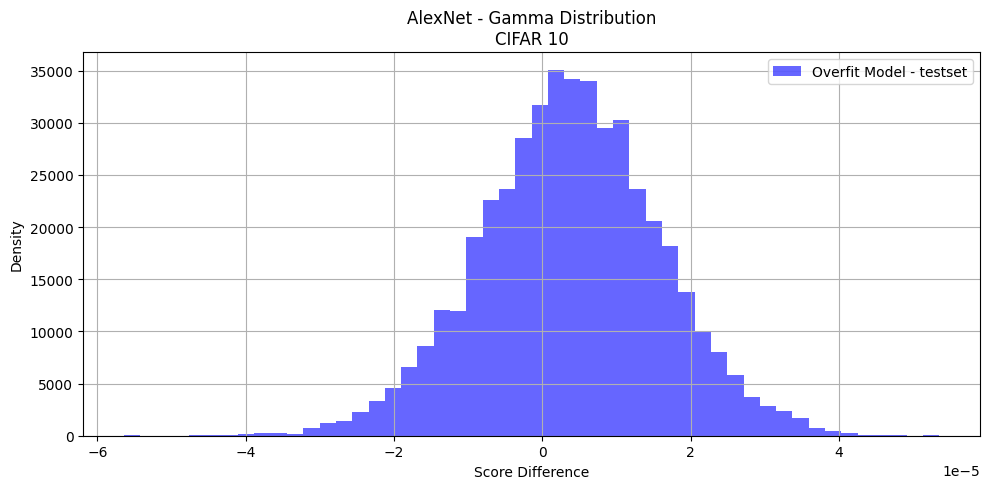

In [8]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(overfit_test, bins=50, alpha=0.6, label="Overfit Model - testset", color="blue", density=True)
# plt.hist(overfit, bins=50, alpha=0.6, label="Overfit Model", color="orange", density=True)
plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"AlexNet - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

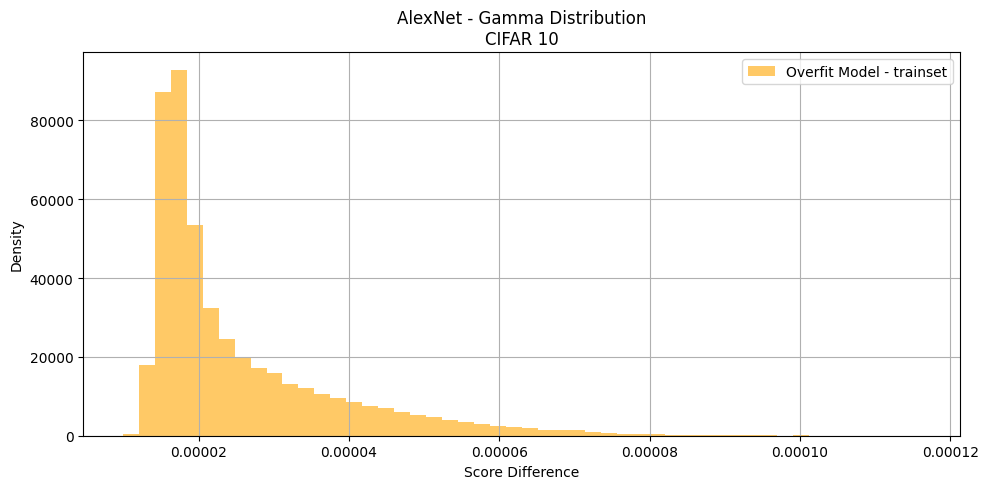

In [9]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
# plt.hist(correct, bins=50, alpha=0.6, label="Correct Model", color="blue", density=True)
plt.hist(overfit_train, bins=50, alpha=0.6, label="Overfit Model - trainset", color="orange", density=True)
plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"AlexNet - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
# plt.savefig("gamma_hist_ResNet18_cifar10.png")
plt.show()

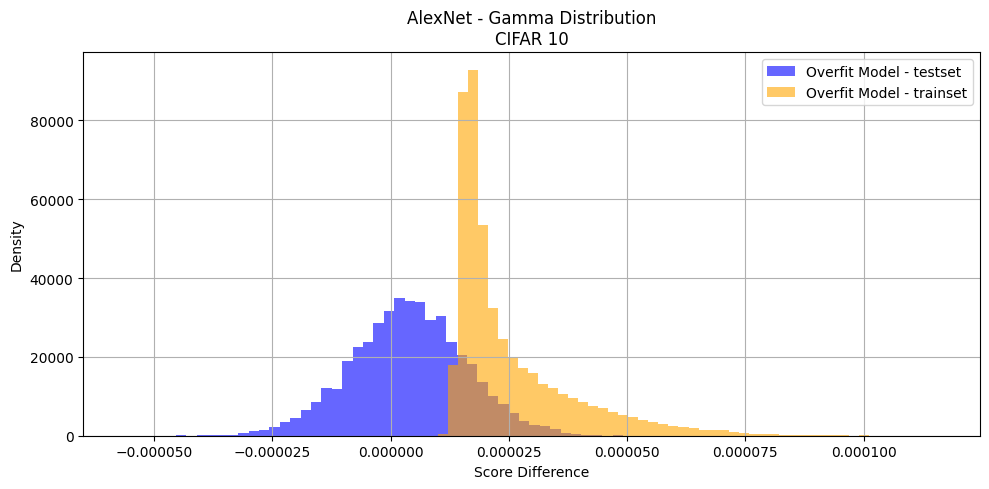

In [11]:
plt.figure(figsize=(10, 5))
# plt.hist(underfit, bins=50, alpha=0.6, label="Underfit Model", color="green", density=True)
plt.hist(overfit_test, bins=50, alpha=0.6, label="Overfit Model - testset", color="blue", density=True)
plt.hist(overfit_train, bins=50, alpha=0.6, label="Overfit Model - trainset", color="orange", density=True)
plt.xlabel("Score Difference")
plt.ylabel("Density")
plt.title(f"AlexNet - Gamma Distribution\nCIFAR 10")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("gamma_hist_alexnet_cifar10_overfit.png")
plt.show()

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR-10 mean/std
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [2]:
class Cifar10AlexNet(nn.Module):
    def __init__(self, num_classes=10, dropout=0.0):
        """
        A Narrow AlexNet adapted for CIFAR-10 (32x32 inputs).
        
        Args:
            num_classes (int): Number of output classes (10 for CIFAR-10).
            dropout (float): Dropout probability. Set to 0.0 to disable for overfitting.
        """
        super(Cifar10AlexNet, self).__init__()
        
        # Feature Extractor
        # Input: 32x32x3
        self.features = nn.Sequential(
            # Conv 1
            # Standard AlexNet uses 11x11 stride 4. We use 5x5 stride 1 for 32x32 img.
            nn.Conv2d(3, 32, kernel_size=5, stride=1, padding=2, bias=True),
            nn.BatchNorm2d(32),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 16x16
            
            # Conv 2
            nn.Conv2d(32, 64, kernel_size=5, stride=1, padding=2, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 8x8
            
            # Conv 3
            # Limited to 64 channels
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Conv 4
            # Limited to 64 channels
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            
            # Conv 5
            # Limited to 64 channels
            nn.Conv2d(64, 64, kernel_size=3, stride=1, padding=1, bias=True),
            nn.BatchNorm2d(64),
            nn.ReLU(inplace=True),
            nn.MaxPool2d(kernel_size=2, stride=2), # Output: 4x4
        )
        
        # Classifier
        # Input size is 64 channels * 4 * 4 spatial dimension = 1024
        self.classifier = nn.Sequential(
            nn.Flatten(),
            
            # FC 1
            nn.Dropout(p=dropout),
            nn.Linear(64 * 4 * 4, 1024, bias=True),
            nn.ReLU(inplace=True),
            
            # FC 2
            nn.Dropout(p=dropout),
            nn.Linear(1024, 512, bias=True),
            nn.ReLU(inplace=True),
            
            # Output Layer
            nn.Linear(512, num_classes, bias=True)
        )

        # Initialize weights
        self.apply(self._init_weights)

    def _init_weights(self, m):
        if isinstance(m, nn.Conv2d) or isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, mode='fan_in', nonlinearity='relu')
            if m.bias is not None:
                nn.init.constant_(m.bias, 0)
        elif isinstance(m, nn.BatchNorm2d):
            nn.init.constant_(m.weight, 1)
            nn.init.constant_(m.bias, 0)

    def forward(self, x):
        x = self.features(x)
        logits = self.classifier(x)
        return logits

In [10]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Cifar10AlexNet().to(device)

In [11]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # Optional: Learning rate scheduler

epochs = 500 # Adjust as needed

train_acc = list()
test_acc = list()
train_loss = list()
test_loss = list()

for epoch in range(epochs):
    model.train()
    train_running_loss = 0.0
    test_running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}, Train: ")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    train_acc_ = 100 * correct / total
    scheduler.step() # If using a scheduler

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_acc_ = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {train_running_loss/len(trainloader):.4f}, train acc: {train_acc_:.2f}%, test acc: {test_acc_:.2f}%")
    train_acc.append(train_acc_)
    test_acc.append(test_acc_)
    train_loss.append(train_running_loss/len(trainloader))
    test_loss.append(test_running_loss/len(testloader))
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"ckpt_alexnet_cifar10_overfit/epoch_{epoch+1}.pth")

Eval: 100%|██████████| 79/79 [00:01<00:00, 67.11it/s]


Epoch 1, Loss: 2.0195, train acc: 30.24%, test acc: 40.44%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.05it/s]


Epoch 2, Loss: 1.5475, train acc: 44.37%, test acc: 45.59%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.18it/s]


Epoch 3, Loss: 1.4127, train acc: 49.20%, test acc: 49.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.29it/s]


Epoch 4, Loss: 1.3277, train acc: 52.57%, test acc: 51.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.43it/s]


Epoch 5, Loss: 1.2629, train acc: 55.06%, test acc: 52.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.20it/s]


Epoch 6, Loss: 1.2093, train acc: 57.08%, test acc: 53.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.78it/s]


Epoch 7, Loss: 1.1638, train acc: 58.82%, test acc: 55.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.31it/s]


Epoch 8, Loss: 1.1186, train acc: 60.49%, test acc: 55.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.10it/s]


Epoch 9, Loss: 1.0783, train acc: 62.04%, test acc: 56.30%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.52it/s]


Epoch 10, Loss: 1.0431, train acc: 63.28%, test acc: 57.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.80it/s]


Epoch 11, Loss: 1.0068, train acc: 64.58%, test acc: 57.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.28it/s]


Epoch 12, Loss: 0.9779, train acc: 65.82%, test acc: 58.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.35it/s]


Epoch 13, Loss: 0.9434, train acc: 66.89%, test acc: 59.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.72it/s]


Epoch 14, Loss: 0.9145, train acc: 68.00%, test acc: 59.61%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.27it/s]


Epoch 15, Loss: 0.8885, train acc: 68.98%, test acc: 59.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.18it/s]


Epoch 16, Loss: 0.8610, train acc: 70.01%, test acc: 60.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.15it/s]


Epoch 17, Loss: 0.8364, train acc: 70.82%, test acc: 60.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.03it/s]


Epoch 18, Loss: 0.8125, train acc: 71.80%, test acc: 61.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.95it/s]


Epoch 19, Loss: 0.7878, train acc: 72.70%, test acc: 61.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.85it/s]


Epoch 20, Loss: 0.7655, train acc: 73.53%, test acc: 60.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.10it/s]


Epoch 21, Loss: 0.7422, train acc: 74.52%, test acc: 61.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.62it/s]


Epoch 22, Loss: 0.7223, train acc: 75.20%, test acc: 61.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.32it/s]


Epoch 23, Loss: 0.7006, train acc: 76.28%, test acc: 61.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.01it/s]


Epoch 24, Loss: 0.6798, train acc: 77.07%, test acc: 62.43%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.20it/s]


Epoch 25, Loss: 0.6606, train acc: 77.71%, test acc: 62.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.89it/s]


Epoch 26, Loss: 0.6405, train acc: 78.56%, test acc: 62.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.77it/s]


Epoch 27, Loss: 0.6222, train acc: 79.08%, test acc: 62.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.06it/s]


Epoch 28, Loss: 0.6005, train acc: 80.05%, test acc: 62.56%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.11it/s]


Epoch 29, Loss: 0.5823, train acc: 80.81%, test acc: 62.42%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.39it/s]


Epoch 30, Loss: 0.5624, train acc: 81.57%, test acc: 62.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.85it/s]


Epoch 31, Loss: 0.5474, train acc: 82.00%, test acc: 62.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.35it/s]


Epoch 32, Loss: 0.5281, train acc: 82.78%, test acc: 62.55%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.07it/s]


Epoch 33, Loss: 0.5101, train acc: 83.62%, test acc: 62.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 69.02it/s]


Epoch 34, Loss: 0.4921, train acc: 84.27%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.85it/s]


Epoch 35, Loss: 0.4748, train acc: 85.03%, test acc: 62.67%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.29it/s]


Epoch 36, Loss: 0.4563, train acc: 85.62%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.36it/s]


Epoch 37, Loss: 0.4420, train acc: 86.20%, test acc: 63.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.77it/s]


Epoch 38, Loss: 0.4273, train acc: 86.79%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.86it/s]


Epoch 39, Loss: 0.4099, train acc: 87.57%, test acc: 63.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.47it/s]


Epoch 40, Loss: 0.3925, train acc: 88.22%, test acc: 63.31%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.27it/s]


Epoch 41, Loss: 0.3765, train acc: 88.83%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.79it/s]


Epoch 42, Loss: 0.3649, train acc: 89.22%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.48it/s]


Epoch 43, Loss: 0.3496, train acc: 89.89%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.09it/s]


Epoch 44, Loss: 0.3311, train acc: 90.74%, test acc: 62.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.35it/s]


Epoch 45, Loss: 0.3219, train acc: 91.02%, test acc: 63.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.25it/s]


Epoch 46, Loss: 0.3062, train acc: 91.63%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.84it/s]


Epoch 47, Loss: 0.2913, train acc: 92.27%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.34it/s]


Epoch 48, Loss: 0.2810, train acc: 92.61%, test acc: 63.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.15it/s]


Epoch 49, Loss: 0.2679, train acc: 93.15%, test acc: 63.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.81it/s]


Epoch 50, Loss: 0.2523, train acc: 93.80%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.05it/s]


Epoch 51, Loss: 0.2416, train acc: 94.15%, test acc: 63.47%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.92it/s]


Epoch 52, Loss: 0.2309, train acc: 94.57%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.92it/s]


Epoch 53, Loss: 0.2197, train acc: 95.06%, test acc: 63.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.32it/s]


Epoch 54, Loss: 0.2094, train acc: 95.42%, test acc: 63.39%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.14it/s]


Epoch 55, Loss: 0.1988, train acc: 95.79%, test acc: 62.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.75it/s]


Epoch 56, Loss: 0.1884, train acc: 96.19%, test acc: 63.29%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.02it/s]


Epoch 57, Loss: 0.1802, train acc: 96.48%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.39it/s]


Epoch 58, Loss: 0.1719, train acc: 96.67%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.79it/s]


Epoch 59, Loss: 0.1623, train acc: 97.07%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 60.43it/s]


Epoch 60, Loss: 0.1553, train acc: 97.29%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.31it/s]


Epoch 61, Loss: 0.1453, train acc: 97.72%, test acc: 63.37%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.67it/s]


Epoch 62, Loss: 0.1382, train acc: 97.88%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.28it/s]


Epoch 63, Loss: 0.1319, train acc: 98.05%, test acc: 63.36%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.04it/s]


Epoch 64, Loss: 0.1240, train acc: 98.35%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.49it/s]


Epoch 65, Loss: 0.1173, train acc: 98.58%, test acc: 63.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.15it/s]


Epoch 66, Loss: 0.1106, train acc: 98.74%, test acc: 63.33%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.21it/s]


Epoch 67, Loss: 0.1065, train acc: 98.81%, test acc: 63.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.61it/s]


Epoch 68, Loss: 0.1010, train acc: 98.95%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.43it/s]


Epoch 69, Loss: 0.0964, train acc: 99.06%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.04it/s]


Epoch 70, Loss: 0.0911, train acc: 99.16%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.87it/s]


Epoch 71, Loss: 0.0863, train acc: 99.31%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.05it/s]


Epoch 72, Loss: 0.0820, train acc: 99.38%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.83it/s]


Epoch 73, Loss: 0.0783, train acc: 99.46%, test acc: 62.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.79it/s]


Epoch 74, Loss: 0.0740, train acc: 99.58%, test acc: 63.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.64it/s]


Epoch 75, Loss: 0.0705, train acc: 99.62%, test acc: 63.27%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.18it/s]


Epoch 76, Loss: 0.0676, train acc: 99.65%, test acc: 63.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.54it/s]


Epoch 77, Loss: 0.0638, train acc: 99.71%, test acc: 62.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.83it/s]


Epoch 78, Loss: 0.0623, train acc: 99.71%, test acc: 63.45%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.35it/s]


Epoch 79, Loss: 0.0590, train acc: 99.76%, test acc: 63.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.55it/s]


Epoch 80, Loss: 0.0565, train acc: 99.82%, test acc: 63.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.26it/s]


Epoch 81, Loss: 0.0538, train acc: 99.83%, test acc: 63.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.23it/s]


Epoch 82, Loss: 0.0512, train acc: 99.87%, test acc: 63.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.22it/s]


Epoch 83, Loss: 0.0501, train acc: 99.85%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.26it/s]


Epoch 84, Loss: 0.0477, train acc: 99.90%, test acc: 63.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.46it/s]


Epoch 85, Loss: 0.0458, train acc: 99.89%, test acc: 63.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.92it/s]


Epoch 86, Loss: 0.0448, train acc: 99.90%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.99it/s]


Epoch 87, Loss: 0.0430, train acc: 99.92%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.31it/s]


Epoch 88, Loss: 0.0417, train acc: 99.93%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.53it/s]


Epoch 89, Loss: 0.0395, train acc: 99.94%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.00it/s]


Epoch 90, Loss: 0.0379, train acc: 99.96%, test acc: 63.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.36it/s]


Epoch 91, Loss: 0.0362, train acc: 99.95%, test acc: 63.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.97it/s]


Epoch 92, Loss: 0.0360, train acc: 99.95%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.71it/s]


Epoch 93, Loss: 0.0353, train acc: 99.96%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.19it/s]


Epoch 94, Loss: 0.0334, train acc: 99.97%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.01it/s]


Epoch 95, Loss: 0.0328, train acc: 99.97%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.69it/s]


Epoch 96, Loss: 0.0316, train acc: 99.96%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.84it/s]


Epoch 97, Loss: 0.0314, train acc: 99.97%, test acc: 63.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.73it/s]


Epoch 98, Loss: 0.0303, train acc: 99.98%, test acc: 63.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.55it/s]


Epoch 99, Loss: 0.0292, train acc: 99.98%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.86it/s]


Epoch 100, Loss: 0.0281, train acc: 99.99%, test acc: 63.28%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.61it/s]


Epoch 101, Loss: 0.0278, train acc: 99.98%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.97it/s]


Epoch 102, Loss: 0.0274, train acc: 99.98%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.56it/s]


Epoch 103, Loss: 0.0261, train acc: 99.99%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.51it/s]


Epoch 104, Loss: 0.0263, train acc: 99.98%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.00it/s]


Epoch 105, Loss: 0.0251, train acc: 99.99%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.51it/s]


Epoch 106, Loss: 0.0251, train acc: 99.99%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.60it/s]


Epoch 107, Loss: 0.0244, train acc: 99.99%, test acc: 63.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.83it/s]


Epoch 108, Loss: 0.0240, train acc: 100.00%, test acc: 63.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.66it/s]


Epoch 109, Loss: 0.0234, train acc: 99.99%, test acc: 63.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.23it/s]


Epoch 110, Loss: 0.0230, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.29it/s]


Epoch 111, Loss: 0.0224, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.71it/s]


Epoch 112, Loss: 0.0225, train acc: 99.99%, test acc: 62.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.22it/s]


Epoch 113, Loss: 0.0218, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.12it/s]


Epoch 114, Loss: 0.0211, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.75it/s]


Epoch 115, Loss: 0.0207, train acc: 100.00%, test acc: 63.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.34it/s]


Epoch 116, Loss: 0.0207, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.10it/s]


Epoch 117, Loss: 0.0202, train acc: 100.00%, test acc: 62.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.24it/s]


Epoch 118, Loss: 0.0199, train acc: 100.00%, test acc: 63.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.40it/s]


Epoch 119, Loss: 0.0198, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.51it/s]


Epoch 120, Loss: 0.0193, train acc: 100.00%, test acc: 63.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.02it/s]


Epoch 121, Loss: 0.0189, train acc: 100.00%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.24it/s]


Epoch 122, Loss: 0.0187, train acc: 100.00%, test acc: 63.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.53it/s]


Epoch 123, Loss: 0.0185, train acc: 100.00%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.84it/s]


Epoch 124, Loss: 0.0182, train acc: 100.00%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.38it/s]


Epoch 125, Loss: 0.0181, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.46it/s]


Epoch 126, Loss: 0.0181, train acc: 100.00%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.38it/s]


Epoch 127, Loss: 0.0175, train acc: 100.00%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.55it/s]


Epoch 128, Loss: 0.0175, train acc: 100.00%, test acc: 63.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.00it/s]


Epoch 129, Loss: 0.0174, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.13it/s]


Epoch 130, Loss: 0.0175, train acc: 100.00%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.55it/s]


Epoch 131, Loss: 0.0167, train acc: 100.00%, test acc: 63.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.19it/s]


Epoch 132, Loss: 0.0167, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.12it/s]


Epoch 133, Loss: 0.0165, train acc: 100.00%, test acc: 63.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.37it/s]


Epoch 134, Loss: 0.0166, train acc: 100.00%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.54it/s]


Epoch 135, Loss: 0.0163, train acc: 100.00%, test acc: 62.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.49it/s]


Epoch 136, Loss: 0.0162, train acc: 100.00%, test acc: 63.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.04it/s]


Epoch 137, Loss: 0.0160, train acc: 100.00%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.91it/s]


Epoch 138, Loss: 0.0160, train acc: 100.00%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.19it/s]


Epoch 139, Loss: 0.0157, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.41it/s]


Epoch 140, Loss: 0.0153, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.26it/s]


Epoch 141, Loss: 0.0153, train acc: 100.00%, test acc: 63.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.47it/s]


Epoch 142, Loss: 0.0150, train acc: 100.00%, test acc: 63.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.17it/s]


Epoch 143, Loss: 0.0152, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.29it/s]


Epoch 144, Loss: 0.0152, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.62it/s]


Epoch 145, Loss: 0.0151, train acc: 100.00%, test acc: 63.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.45it/s]


Epoch 146, Loss: 0.0153, train acc: 100.00%, test acc: 63.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.84it/s]


Epoch 147, Loss: 0.0152, train acc: 100.00%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.96it/s]


Epoch 148, Loss: 0.0147, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.72it/s]


Epoch 149, Loss: 0.0144, train acc: 100.00%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.02it/s]


Epoch 150, Loss: 0.0144, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.81it/s]


Epoch 151, Loss: 0.0145, train acc: 100.00%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.98it/s]


Epoch 152, Loss: 0.0144, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.10it/s]


Epoch 153, Loss: 0.0144, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.93it/s]


Epoch 154, Loss: 0.0144, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.63it/s]


Epoch 155, Loss: 0.0143, train acc: 100.00%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.77it/s]


Epoch 156, Loss: 0.0142, train acc: 100.00%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.35it/s]


Epoch 157, Loss: 0.0138, train acc: 100.00%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.78it/s]


Epoch 158, Loss: 0.0141, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.93it/s]


Epoch 159, Loss: 0.0144, train acc: 100.00%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.58it/s]


Epoch 160, Loss: 0.0138, train acc: 100.00%, test acc: 63.25%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.50it/s]


Epoch 161, Loss: 0.0140, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.98it/s]


Epoch 162, Loss: 0.0137, train acc: 100.00%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.21it/s]


Epoch 163, Loss: 0.0136, train acc: 100.00%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.44it/s]


Epoch 164, Loss: 0.0137, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.28it/s]


Epoch 165, Loss: 0.0137, train acc: 100.00%, test acc: 63.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.03it/s]


Epoch 166, Loss: 0.0138, train acc: 100.00%, test acc: 63.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.61it/s]


Epoch 167, Loss: 0.0135, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.19it/s]


Epoch 168, Loss: 0.0137, train acc: 100.00%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.40it/s]


Epoch 169, Loss: 0.0133, train acc: 100.00%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.82it/s]


Epoch 170, Loss: 0.0139, train acc: 100.00%, test acc: 63.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.47it/s]


Epoch 171, Loss: 0.0135, train acc: 100.00%, test acc: 63.26%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.86it/s]


Epoch 172, Loss: 0.0133, train acc: 100.00%, test acc: 63.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.92it/s]


Epoch 173, Loss: 0.0132, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.79it/s]


Epoch 174, Loss: 0.0136, train acc: 100.00%, test acc: 63.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 60.70it/s]


Epoch 175, Loss: 0.0134, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.71it/s]


Epoch 176, Loss: 0.0134, train acc: 100.00%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.38it/s]


Epoch 177, Loss: 0.0134, train acc: 100.00%, test acc: 63.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.15it/s]


Epoch 178, Loss: 0.0134, train acc: 100.00%, test acc: 63.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.76it/s]


Epoch 179, Loss: 0.0132, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.11it/s]


Epoch 180, Loss: 0.0135, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.30it/s]


Epoch 181, Loss: 0.0134, train acc: 100.00%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.76it/s]


Epoch 182, Loss: 0.0132, train acc: 100.00%, test acc: 63.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.60it/s]


Epoch 183, Loss: 0.0133, train acc: 100.00%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.28it/s]


Epoch 184, Loss: 0.0132, train acc: 100.00%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.63it/s]


Epoch 185, Loss: 0.0131, train acc: 100.00%, test acc: 63.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.76it/s]


Epoch 186, Loss: 0.0133, train acc: 100.00%, test acc: 63.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.01it/s]


Epoch 187, Loss: 0.0132, train acc: 100.00%, test acc: 63.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.97it/s]


Epoch 188, Loss: 0.0132, train acc: 100.00%, test acc: 63.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.71it/s]


Epoch 189, Loss: 0.0132, train acc: 100.00%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.47it/s]


Epoch 190, Loss: 0.0133, train acc: 100.00%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.38it/s]


Epoch 191, Loss: 0.0131, train acc: 100.00%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.63it/s]


Epoch 192, Loss: 0.0131, train acc: 100.00%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.77it/s]


Epoch 193, Loss: 0.0133, train acc: 100.00%, test acc: 63.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.41it/s]


Epoch 194, Loss: 0.0133, train acc: 100.00%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.14it/s]


Epoch 195, Loss: 0.0133, train acc: 100.00%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.98it/s]


Epoch 196, Loss: 0.0131, train acc: 100.00%, test acc: 63.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.77it/s]


Epoch 197, Loss: 0.0132, train acc: 100.00%, test acc: 63.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.76it/s]


Epoch 198, Loss: 0.0133, train acc: 100.00%, test acc: 63.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.01it/s]


Epoch 199, Loss: 0.0133, train acc: 100.00%, test acc: 63.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.72it/s]


Epoch 200, Loss: 0.0135, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.18it/s]


Epoch 201, Loss: 0.0130, train acc: 100.00%, test acc: 63.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.03it/s]


Epoch 202, Loss: 0.0133, train acc: 100.00%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.81it/s]


Epoch 203, Loss: 0.0131, train acc: 100.00%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.05it/s]


Epoch 204, Loss: 0.0133, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.86it/s]


Epoch 205, Loss: 0.0131, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.66it/s]


Epoch 206, Loss: 0.0132, train acc: 100.00%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.73it/s]


Epoch 207, Loss: 0.0136, train acc: 100.00%, test acc: 63.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.40it/s]


Epoch 208, Loss: 0.0134, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.68it/s]


Epoch 209, Loss: 0.0131, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.91it/s]


Epoch 210, Loss: 0.0134, train acc: 100.00%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.86it/s]


Epoch 211, Loss: 0.0131, train acc: 100.00%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 55.23it/s]


Epoch 212, Loss: 0.0130, train acc: 100.00%, test acc: 63.18%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.57it/s]


Epoch 213, Loss: 0.0131, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.51it/s]


Epoch 214, Loss: 0.0131, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.62it/s]


Epoch 215, Loss: 0.0133, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.20it/s]


Epoch 216, Loss: 0.0132, train acc: 100.00%, test acc: 63.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.41it/s]


Epoch 217, Loss: 0.0131, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.76it/s]


Epoch 218, Loss: 0.0132, train acc: 100.00%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.07it/s]


Epoch 219, Loss: 0.0134, train acc: 100.00%, test acc: 63.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.40it/s]


Epoch 220, Loss: 0.0131, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.02it/s]


Epoch 221, Loss: 0.0134, train acc: 100.00%, test acc: 63.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.50it/s]


Epoch 222, Loss: 0.0132, train acc: 100.00%, test acc: 63.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.53it/s]


Epoch 223, Loss: 0.0130, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.72it/s]


Epoch 224, Loss: 0.0131, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.14it/s]


Epoch 225, Loss: 0.0131, train acc: 100.00%, test acc: 63.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.99it/s]


Epoch 226, Loss: 0.0134, train acc: 100.00%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.97it/s]


Epoch 227, Loss: 0.0133, train acc: 100.00%, test acc: 63.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.50it/s]


Epoch 228, Loss: 0.0132, train acc: 100.00%, test acc: 63.19%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.45it/s]


Epoch 229, Loss: 0.0134, train acc: 100.00%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.17it/s]


Epoch 230, Loss: 0.0132, train acc: 100.00%, test acc: 63.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.32it/s]


Epoch 231, Loss: 0.0129, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.01it/s]


Epoch 232, Loss: 0.0130, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.66it/s]


Epoch 233, Loss: 0.0130, train acc: 100.00%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.16it/s]


Epoch 234, Loss: 0.0131, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.95it/s]


Epoch 235, Loss: 0.0131, train acc: 100.00%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.45it/s]


Epoch 236, Loss: 0.0129, train acc: 100.00%, test acc: 63.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.66it/s]


Epoch 237, Loss: 0.0131, train acc: 100.00%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.72it/s]


Epoch 238, Loss: 0.0129, train acc: 100.00%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.15it/s]


Epoch 239, Loss: 0.0127, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.20it/s]


Epoch 240, Loss: 0.0129, train acc: 100.00%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.65it/s]


Epoch 241, Loss: 0.0128, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.15it/s]


Epoch 242, Loss: 0.0129, train acc: 100.00%, test acc: 63.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.81it/s]


Epoch 243, Loss: 0.0129, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.67it/s]


Epoch 244, Loss: 0.0128, train acc: 100.00%, test acc: 62.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 60.57it/s]


Epoch 245, Loss: 0.0130, train acc: 100.00%, test acc: 63.11%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.43it/s]


Epoch 246, Loss: 0.0127, train acc: 100.00%, test acc: 63.13%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.20it/s]


Epoch 247, Loss: 0.0128, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.47it/s]


Epoch 248, Loss: 0.0127, train acc: 100.00%, test acc: 63.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.46it/s]


Epoch 249, Loss: 0.0129, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.86it/s]


Epoch 250, Loss: 0.0125, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.79it/s]


Epoch 251, Loss: 0.0123, train acc: 100.00%, test acc: 63.21%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.57it/s]


Epoch 252, Loss: 0.0124, train acc: 100.00%, test acc: 63.20%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.90it/s]


Epoch 253, Loss: 0.0123, train acc: 100.00%, test acc: 63.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.61it/s]


Epoch 254, Loss: 0.0121, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.62it/s]


Epoch 255, Loss: 0.0126, train acc: 100.00%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.36it/s]


Epoch 256, Loss: 0.0124, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.28it/s]


Epoch 257, Loss: 0.0122, train acc: 100.00%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.47it/s]


Epoch 258, Loss: 0.0121, train acc: 100.00%, test acc: 62.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.28it/s]


Epoch 259, Loss: 0.0121, train acc: 100.00%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.62it/s]


Epoch 260, Loss: 0.0121, train acc: 100.00%, test acc: 63.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.15it/s]


Epoch 261, Loss: 0.0119, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.41it/s]


Epoch 262, Loss: 0.0120, train acc: 100.00%, test acc: 63.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.88it/s]


Epoch 263, Loss: 0.0117, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.79it/s]


Epoch 264, Loss: 0.0120, train acc: 100.00%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.22it/s]


Epoch 265, Loss: 0.0117, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.50it/s]


Epoch 266, Loss: 0.0119, train acc: 100.00%, test acc: 63.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.07it/s]


Epoch 267, Loss: 0.0116, train acc: 100.00%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.07it/s]


Epoch 268, Loss: 0.0117, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.23it/s]


Epoch 269, Loss: 0.0115, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.27it/s]


Epoch 270, Loss: 0.0113, train acc: 100.00%, test acc: 63.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.85it/s]


Epoch 271, Loss: 0.0115, train acc: 100.00%, test acc: 63.08%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.26it/s]


Epoch 272, Loss: 0.0112, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.50it/s]


Epoch 273, Loss: 0.0114, train acc: 100.00%, test acc: 63.10%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.81it/s]


Epoch 274, Loss: 0.0110, train acc: 100.00%, test acc: 63.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.93it/s]


Epoch 275, Loss: 0.0110, train acc: 100.00%, test acc: 63.15%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.73it/s]


Epoch 276, Loss: 0.0108, train acc: 100.00%, test acc: 63.14%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.68it/s]


Epoch 277, Loss: 0.0108, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.49it/s]


Epoch 278, Loss: 0.0109, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.48it/s]


Epoch 279, Loss: 0.0106, train acc: 100.00%, test acc: 63.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.34it/s]


Epoch 280, Loss: 0.0106, train acc: 100.00%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.40it/s]


Epoch 281, Loss: 0.0105, train acc: 100.00%, test acc: 63.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.45it/s]


Epoch 282, Loss: 0.0105, train acc: 100.00%, test acc: 63.12%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.00it/s]


Epoch 283, Loss: 0.0102, train acc: 100.00%, test acc: 63.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.14it/s]


Epoch 284, Loss: 0.0105, train acc: 100.00%, test acc: 62.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.12it/s]


Epoch 285, Loss: 0.0103, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.54it/s]


Epoch 286, Loss: 0.0103, train acc: 100.00%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.40it/s]


Epoch 287, Loss: 0.0099, train acc: 100.00%, test acc: 63.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.54it/s]


Epoch 288, Loss: 0.0101, train acc: 100.00%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.28it/s]


Epoch 289, Loss: 0.0099, train acc: 100.00%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.44it/s]


Epoch 290, Loss: 0.0096, train acc: 100.00%, test acc: 62.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.16it/s]


Epoch 291, Loss: 0.0098, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.39it/s]


Epoch 292, Loss: 0.0096, train acc: 100.00%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.43it/s]


Epoch 293, Loss: 0.0093, train acc: 100.00%, test acc: 63.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.55it/s]


Epoch 294, Loss: 0.0094, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.89it/s]


Epoch 295, Loss: 0.0095, train acc: 100.00%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.80it/s]


Epoch 296, Loss: 0.0092, train acc: 100.00%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.76it/s]


Epoch 297, Loss: 0.0093, train acc: 100.00%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.89it/s]


Epoch 298, Loss: 0.0092, train acc: 100.00%, test acc: 63.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.27it/s]


Epoch 299, Loss: 0.0090, train acc: 100.00%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.04it/s]


Epoch 300, Loss: 0.0087, train acc: 100.00%, test acc: 63.03%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.60it/s]


Epoch 301, Loss: 0.0089, train acc: 100.00%, test acc: 63.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.71it/s]


Epoch 302, Loss: 0.0087, train acc: 100.00%, test acc: 62.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.05it/s]


Epoch 303, Loss: 0.0086, train acc: 100.00%, test acc: 62.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.92it/s]


Epoch 304, Loss: 0.0085, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.55it/s]


Epoch 305, Loss: 0.0082, train acc: 100.00%, test acc: 63.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.01it/s]


Epoch 306, Loss: 0.0084, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.87it/s]


Epoch 307, Loss: 0.0081, train acc: 100.00%, test acc: 62.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.27it/s]


Epoch 308, Loss: 0.0079, train acc: 100.00%, test acc: 62.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.16it/s]


Epoch 309, Loss: 0.0079, train acc: 100.00%, test acc: 63.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.57it/s]


Epoch 310, Loss: 0.0078, train acc: 100.00%, test acc: 63.07%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.41it/s]


Epoch 311, Loss: 0.0079, train acc: 100.00%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.89it/s]


Epoch 312, Loss: 0.0077, train acc: 100.00%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.66it/s]


Epoch 313, Loss: 0.0076, train acc: 100.00%, test acc: 62.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.03it/s]


Epoch 314, Loss: 0.0076, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.57it/s]


Epoch 315, Loss: 0.0075, train acc: 100.00%, test acc: 62.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.22it/s]


Epoch 316, Loss: 0.0072, train acc: 100.00%, test acc: 63.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.50it/s]


Epoch 317, Loss: 0.0073, train acc: 100.00%, test acc: 63.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.38it/s]


Epoch 318, Loss: 0.0072, train acc: 100.00%, test acc: 63.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.50it/s]


Epoch 319, Loss: 0.0070, train acc: 100.00%, test acc: 62.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.75it/s]


Epoch 320, Loss: 0.0071, train acc: 100.00%, test acc: 62.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.66it/s]


Epoch 321, Loss: 0.0070, train acc: 100.00%, test acc: 62.99%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.45it/s]


Epoch 322, Loss: 0.0069, train acc: 100.00%, test acc: 62.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.95it/s]


Epoch 323, Loss: 0.0069, train acc: 100.00%, test acc: 62.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.46it/s]


Epoch 324, Loss: 0.0066, train acc: 100.00%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.91it/s]


Epoch 325, Loss: 0.0067, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.76it/s]


Epoch 326, Loss: 0.0066, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.39it/s]


Epoch 327, Loss: 0.0065, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.39it/s]


Epoch 328, Loss: 0.0062, train acc: 100.00%, test acc: 62.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.71it/s]


Epoch 329, Loss: 0.0062, train acc: 100.00%, test acc: 63.01%


Eval: 100%|██████████| 79/79 [00:01<00:00, 60.54it/s]


Epoch 330, Loss: 0.0060, train acc: 100.00%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.93it/s]


Epoch 331, Loss: 0.0062, train acc: 100.00%, test acc: 62.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.13it/s]


Epoch 332, Loss: 0.0061, train acc: 100.00%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.96it/s]


Epoch 333, Loss: 0.0057, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.40it/s]


Epoch 334, Loss: 0.0058, train acc: 100.00%, test acc: 62.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.53it/s]


Epoch 335, Loss: 0.0058, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.97it/s]


Epoch 336, Loss: 0.0056, train acc: 100.00%, test acc: 62.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.87it/s]


Epoch 337, Loss: 0.0055, train acc: 100.00%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.58it/s]


Epoch 338, Loss: 0.0056, train acc: 100.00%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.29it/s]


Epoch 339, Loss: 0.0055, train acc: 100.00%, test acc: 63.05%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.60it/s]


Epoch 340, Loss: 0.0054, train acc: 100.00%, test acc: 62.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.75it/s]


Epoch 341, Loss: 0.0053, train acc: 100.00%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.97it/s]


Epoch 342, Loss: 0.0056, train acc: 100.00%, test acc: 62.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.55it/s]


Epoch 343, Loss: 0.0054, train acc: 100.00%, test acc: 62.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.31it/s]


Epoch 344, Loss: 0.0052, train acc: 100.00%, test acc: 62.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.10it/s]


Epoch 345, Loss: 0.0051, train acc: 100.00%, test acc: 62.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.59it/s]


Epoch 346, Loss: 0.0051, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.78it/s]


Epoch 347, Loss: 0.0050, train acc: 100.00%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.79it/s]


Epoch 348, Loss: 0.0048, train acc: 100.00%, test acc: 62.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.31it/s]


Epoch 349, Loss: 0.0050, train acc: 100.00%, test acc: 62.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.12it/s]


Epoch 350, Loss: 0.0048, train acc: 100.00%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.79it/s]


Epoch 351, Loss: 0.0048, train acc: 100.00%, test acc: 62.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.12it/s]


Epoch 352, Loss: 0.0048, train acc: 100.00%, test acc: 62.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.53it/s]


Epoch 353, Loss: 0.0047, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.63it/s]


Epoch 354, Loss: 0.0046, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.84it/s]


Epoch 355, Loss: 0.0046, train acc: 100.00%, test acc: 62.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.06it/s]


Epoch 356, Loss: 0.0045, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.49it/s]


Epoch 357, Loss: 0.0045, train acc: 100.00%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.86it/s]


Epoch 358, Loss: 0.0044, train acc: 100.00%, test acc: 62.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.92it/s]


Epoch 359, Loss: 0.0045, train acc: 100.00%, test acc: 62.68%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.45it/s]


Epoch 360, Loss: 0.0044, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.01it/s]


Epoch 361, Loss: 0.0041, train acc: 100.00%, test acc: 63.00%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.88it/s]


Epoch 362, Loss: 0.0041, train acc: 100.00%, test acc: 62.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.12it/s]


Epoch 363, Loss: 0.0040, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.48it/s]


Epoch 364, Loss: 0.0040, train acc: 100.00%, test acc: 62.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.99it/s]


Epoch 365, Loss: 0.0040, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.06it/s]


Epoch 366, Loss: 0.0040, train acc: 100.00%, test acc: 62.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.73it/s]


Epoch 367, Loss: 0.0038, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 60.94it/s]


Epoch 368, Loss: 0.0038, train acc: 100.00%, test acc: 63.04%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.26it/s]


Epoch 369, Loss: 0.0039, train acc: 100.00%, test acc: 62.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.85it/s]


Epoch 370, Loss: 0.0037, train acc: 100.00%, test acc: 62.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.21it/s]


Epoch 371, Loss: 0.0038, train acc: 100.00%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.83it/s]


Epoch 372, Loss: 0.0036, train acc: 100.00%, test acc: 62.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.86it/s]


Epoch 373, Loss: 0.0035, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.12it/s]


Epoch 374, Loss: 0.0036, train acc: 100.00%, test acc: 62.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.84it/s]


Epoch 375, Loss: 0.0036, train acc: 100.00%, test acc: 62.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.43it/s]


Epoch 376, Loss: 0.0035, train acc: 100.00%, test acc: 62.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.48it/s]


Epoch 377, Loss: 0.0036, train acc: 100.00%, test acc: 62.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.31it/s]


Epoch 378, Loss: 0.0034, train acc: 100.00%, test acc: 62.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.94it/s]


Epoch 379, Loss: 0.0034, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.58it/s]


Epoch 380, Loss: 0.0034, train acc: 100.00%, test acc: 62.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.03it/s]


Epoch 381, Loss: 0.0033, train acc: 100.00%, test acc: 62.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.77it/s]


Epoch 382, Loss: 0.0033, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.44it/s]


Epoch 383, Loss: 0.0032, train acc: 100.00%, test acc: 62.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.42it/s]


Epoch 384, Loss: 0.0031, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.87it/s]


Epoch 385, Loss: 0.0031, train acc: 100.00%, test acc: 62.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.62it/s]


Epoch 386, Loss: 0.0031, train acc: 100.00%, test acc: 62.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.57it/s]


Epoch 387, Loss: 0.0032, train acc: 100.00%, test acc: 62.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.35it/s]


Epoch 388, Loss: 0.0031, train acc: 100.00%, test acc: 62.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 56.78it/s]


Epoch 389, Loss: 0.0031, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.47it/s]


Epoch 390, Loss: 0.0030, train acc: 100.00%, test acc: 62.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.14it/s]


Epoch 391, Loss: 0.0031, train acc: 100.00%, test acc: 62.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.69it/s]


Epoch 392, Loss: 0.0029, train acc: 100.00%, test acc: 62.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.12it/s]


Epoch 393, Loss: 0.0030, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.88it/s]


Epoch 394, Loss: 0.0028, train acc: 100.00%, test acc: 62.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.04it/s]


Epoch 395, Loss: 0.0031, train acc: 100.00%, test acc: 62.78%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.64it/s]


Epoch 396, Loss: 0.0031, train acc: 100.00%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.66it/s]


Epoch 397, Loss: 0.0028, train acc: 100.00%, test acc: 62.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.79it/s]


Epoch 398, Loss: 0.0028, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.58it/s]


Epoch 399, Loss: 0.0027, train acc: 100.00%, test acc: 62.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.91it/s]


Epoch 400, Loss: 0.0027, train acc: 100.00%, test acc: 62.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.74it/s]


Epoch 401, Loss: 0.0027, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.45it/s]


Epoch 402, Loss: 0.0027, train acc: 100.00%, test acc: 63.02%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.60it/s]


Epoch 403, Loss: 0.0026, train acc: 100.00%, test acc: 62.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.78it/s]


Epoch 404, Loss: 0.0026, train acc: 100.00%, test acc: 62.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.27it/s]


Epoch 405, Loss: 0.0026, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.23it/s]


Epoch 406, Loss: 0.0026, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.50it/s]


Epoch 407, Loss: 0.0027, train acc: 100.00%, test acc: 62.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.35it/s]


Epoch 408, Loss: 0.0025, train acc: 100.00%, test acc: 62.71%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.50it/s]


Epoch 409, Loss: 0.0024, train acc: 100.00%, test acc: 62.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.76it/s]


Epoch 410, Loss: 0.0025, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.73it/s]


Epoch 411, Loss: 0.0025, train acc: 100.00%, test acc: 62.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.23it/s]


Epoch 412, Loss: 0.0023, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.91it/s]


Epoch 413, Loss: 0.0024, train acc: 100.00%, test acc: 62.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.69it/s]


Epoch 414, Loss: 0.0024, train acc: 100.00%, test acc: 62.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.01it/s]


Epoch 415, Loss: 0.0025, train acc: 100.00%, test acc: 62.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.08it/s]


Epoch 416, Loss: 0.0024, train acc: 100.00%, test acc: 62.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.14it/s]


Epoch 417, Loss: 0.0023, train acc: 100.00%, test acc: 62.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.37it/s]


Epoch 418, Loss: 0.0023, train acc: 100.00%, test acc: 62.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.75it/s]


Epoch 419, Loss: 0.0022, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.59it/s]


Epoch 420, Loss: 0.0023, train acc: 100.00%, test acc: 62.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.30it/s]


Epoch 421, Loss: 0.0022, train acc: 100.00%, test acc: 62.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.04it/s]


Epoch 422, Loss: 0.0022, train acc: 100.00%, test acc: 62.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.92it/s]


Epoch 423, Loss: 0.0022, train acc: 100.00%, test acc: 62.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.21it/s]


Epoch 424, Loss: 0.0022, train acc: 100.00%, test acc: 62.94%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.93it/s]


Epoch 425, Loss: 0.0022, train acc: 100.00%, test acc: 62.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.26it/s]


Epoch 426, Loss: 0.0022, train acc: 100.00%, test acc: 62.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.40it/s]


Epoch 427, Loss: 0.0021, train acc: 100.00%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.76it/s]


Epoch 428, Loss: 0.0021, train acc: 100.00%, test acc: 62.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.42it/s]


Epoch 429, Loss: 0.0021, train acc: 100.00%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.89it/s]


Epoch 430, Loss: 0.0021, train acc: 100.00%, test acc: 62.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.39it/s]


Epoch 431, Loss: 0.0021, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.25it/s]


Epoch 432, Loss: 0.0020, train acc: 100.00%, test acc: 62.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.04it/s]


Epoch 433, Loss: 0.0020, train acc: 100.00%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.59it/s]


Epoch 434, Loss: 0.0020, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.34it/s]


Epoch 435, Loss: 0.0020, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.35it/s]


Epoch 436, Loss: 0.0020, train acc: 100.00%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.14it/s]


Epoch 437, Loss: 0.0019, train acc: 100.00%, test acc: 62.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.99it/s]


Epoch 438, Loss: 0.0019, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.73it/s]


Epoch 439, Loss: 0.0019, train acc: 100.00%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.11it/s]


Epoch 440, Loss: 0.0019, train acc: 100.00%, test acc: 62.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.86it/s]


Epoch 441, Loss: 0.0019, train acc: 100.00%, test acc: 62.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.86it/s]


Epoch 442, Loss: 0.0019, train acc: 100.00%, test acc: 62.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.91it/s]


Epoch 443, Loss: 0.0019, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.23it/s]


Epoch 444, Loss: 0.0019, train acc: 100.00%, test acc: 62.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.35it/s]


Epoch 445, Loss: 0.0018, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.92it/s]


Epoch 446, Loss: 0.0018, train acc: 100.00%, test acc: 62.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.54it/s]


Epoch 447, Loss: 0.0019, train acc: 100.00%, test acc: 62.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.98it/s]


Epoch 448, Loss: 0.0018, train acc: 100.00%, test acc: 62.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.20it/s]


Epoch 449, Loss: 0.0019, train acc: 100.00%, test acc: 62.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.34it/s]


Epoch 450, Loss: 0.0018, train acc: 100.00%, test acc: 62.71%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.68it/s]


Epoch 451, Loss: 0.0017, train acc: 100.00%, test acc: 62.97%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.78it/s]


Epoch 452, Loss: 0.0018, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.18it/s]


Epoch 453, Loss: 0.0017, train acc: 100.00%, test acc: 62.93%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.45it/s]


Epoch 454, Loss: 0.0018, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.52it/s]


Epoch 455, Loss: 0.0018, train acc: 100.00%, test acc: 62.95%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.62it/s]


Epoch 456, Loss: 0.0017, train acc: 100.00%, test acc: 62.80%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.45it/s]


Epoch 457, Loss: 0.0017, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.08it/s]


Epoch 458, Loss: 0.0017, train acc: 100.00%, test acc: 62.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.40it/s]


Epoch 459, Loss: 0.0016, train acc: 100.00%, test acc: 62.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.29it/s]


Epoch 460, Loss: 0.0017, train acc: 100.00%, test acc: 62.91%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.73it/s]


Epoch 461, Loss: 0.0016, train acc: 100.00%, test acc: 62.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.17it/s]


Epoch 462, Loss: 0.0017, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.46it/s]


Epoch 463, Loss: 0.0017, train acc: 100.00%, test acc: 62.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.56it/s]


Epoch 464, Loss: 0.0017, train acc: 100.00%, test acc: 62.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.87it/s]


Epoch 465, Loss: 0.0016, train acc: 100.00%, test acc: 62.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.79it/s]


Epoch 466, Loss: 0.0017, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.50it/s]


Epoch 467, Loss: 0.0016, train acc: 100.00%, test acc: 62.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.01it/s]


Epoch 468, Loss: 0.0016, train acc: 100.00%, test acc: 62.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.70it/s]


Epoch 469, Loss: 0.0016, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.45it/s]


Epoch 470, Loss: 0.0016, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.05it/s]


Epoch 471, Loss: 0.0016, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.40it/s]


Epoch 472, Loss: 0.0016, train acc: 100.00%, test acc: 62.72%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.39it/s]


Epoch 473, Loss: 0.0016, train acc: 100.00%, test acc: 62.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.72it/s]


Epoch 474, Loss: 0.0016, train acc: 100.00%, test acc: 62.81%


Eval: 100%|██████████| 79/79 [00:01<00:00, 68.36it/s]


Epoch 475, Loss: 0.0015, train acc: 100.00%, test acc: 62.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.78it/s]


Epoch 476, Loss: 0.0015, train acc: 100.00%, test acc: 62.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.87it/s]


Epoch 477, Loss: 0.0015, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.19it/s]


Epoch 478, Loss: 0.0015, train acc: 100.00%, test acc: 62.88%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.97it/s]


Epoch 479, Loss: 0.0015, train acc: 100.00%, test acc: 62.78%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.81it/s]


Epoch 480, Loss: 0.0015, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.13it/s]


Epoch 481, Loss: 0.0015, train acc: 100.00%, test acc: 62.70%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.94it/s]


Epoch 482, Loss: 0.0015, train acc: 100.00%, test acc: 62.83%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.78it/s]


Epoch 483, Loss: 0.0015, train acc: 100.00%, test acc: 62.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.49it/s]


Epoch 484, Loss: 0.0015, train acc: 100.00%, test acc: 62.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.22it/s]


Epoch 485, Loss: 0.0015, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.13it/s]


Epoch 486, Loss: 0.0015, train acc: 100.00%, test acc: 62.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.38it/s]


Epoch 487, Loss: 0.0016, train acc: 100.00%, test acc: 62.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.54it/s]


Epoch 488, Loss: 0.0015, train acc: 100.00%, test acc: 62.79%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.01it/s]


Epoch 489, Loss: 0.0015, train acc: 100.00%, test acc: 62.85%


Eval: 100%|██████████| 79/79 [00:01<00:00, 64.10it/s]


Epoch 490, Loss: 0.0015, train acc: 100.00%, test acc: 62.98%


Eval: 100%|██████████| 79/79 [00:01<00:00, 66.89it/s]


Epoch 491, Loss: 0.0014, train acc: 100.00%, test acc: 62.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 57.70it/s]


Epoch 492, Loss: 0.0014, train acc: 100.00%, test acc: 62.82%


Eval: 100%|██████████| 79/79 [00:01<00:00, 63.22it/s]


Epoch 493, Loss: 0.0014, train acc: 100.00%, test acc: 62.89%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.61it/s]


Epoch 494, Loss: 0.0014, train acc: 100.00%, test acc: 62.86%


Eval: 100%|██████████| 79/79 [00:01<00:00, 59.83it/s]


Epoch 495, Loss: 0.0015, train acc: 100.00%, test acc: 62.92%


Eval: 100%|██████████| 79/79 [00:01<00:00, 62.04it/s]


Epoch 496, Loss: 0.0015, train acc: 100.00%, test acc: 62.84%


Eval: 100%|██████████| 79/79 [00:01<00:00, 58.49it/s]


Epoch 497, Loss: 0.0014, train acc: 100.00%, test acc: 62.90%


Eval: 100%|██████████| 79/79 [00:01<00:00, 61.74it/s]


Epoch 498, Loss: 0.0014, train acc: 100.00%, test acc: 62.77%


Eval: 100%|██████████| 79/79 [00:01<00:00, 67.38it/s]


Epoch 499, Loss: 0.0014, train acc: 100.00%, test acc: 62.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 65.59it/s]

Epoch 500, Loss: 0.0014, train acc: 100.00%, test acc: 62.87%


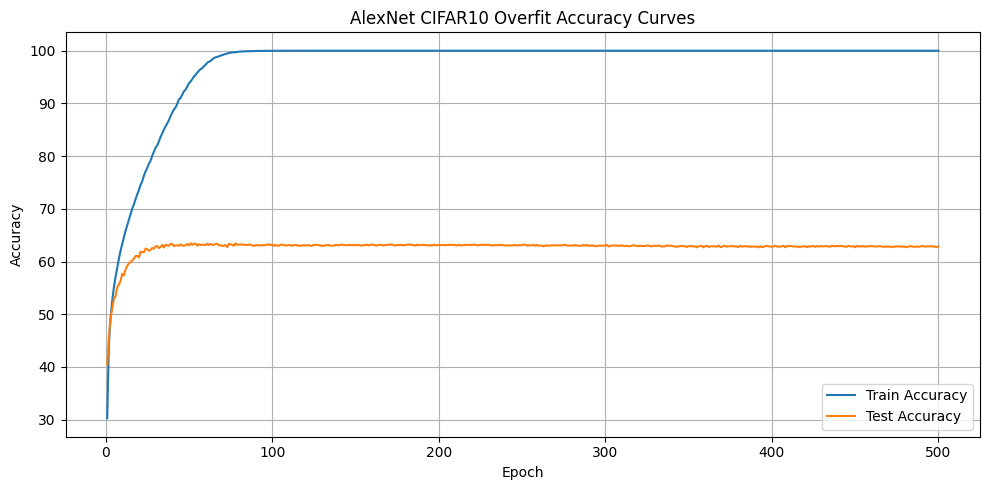

In [12]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"AlexNet CIFAR10 Overfit Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"alexnet_cifar10_overfit_accuracy_curve.png")
plt.show()

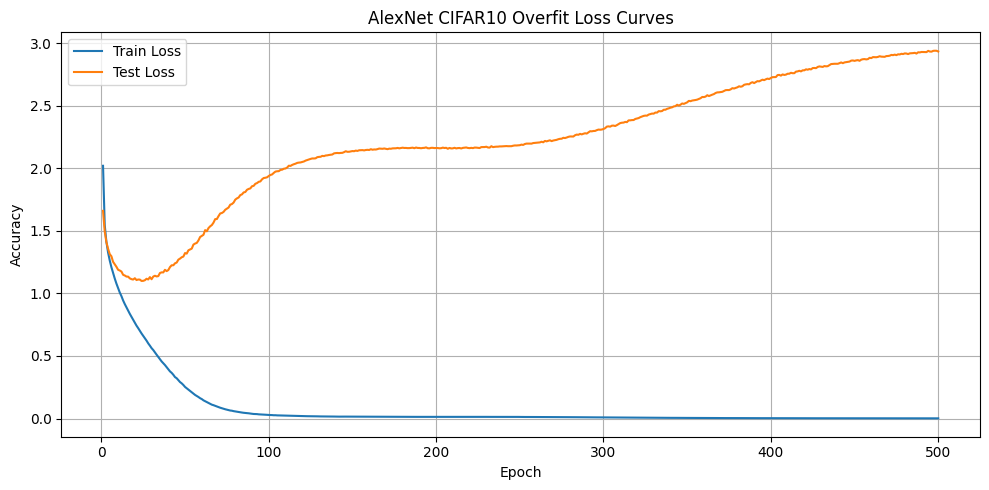

In [14]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"AlexNet CIFAR10 Overfit Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"alexnet_cifar10_overfit_loss_curve.png")
plt.show()

In [12]:
transform_train = transforms.Compose([
    transforms.RandomCrop(32, padding=4),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR-10 mean/std
])

transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010)) # CIFAR-10 mean/std
])

trainset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=transform_train)
trainloader = torch.utils.data.DataLoader(trainset, batch_size=512, shuffle=True, num_workers=2)

testset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=128, shuffle=False, num_workers=2)

In [13]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
model = Cifar10AlexNet().to(device)

In [14]:
criterion = nn.CrossEntropyLoss()
# optimizer = optim.Adam(model.parameters(), lr=0.01, weight_decay=0)
optimizer = optim.SGD(model.parameters(), lr=0.001, momentum=0.9, weight_decay=5e-4)
scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(optimizer, T_max=200) # Optional: Learning rate scheduler

epochs = 200 # Adjust as needed

train_acc = list()
test_acc = list()
train_loss = list()
test_loss = list()

for epoch in range(epochs):
    model.train()
    train_running_loss = 0.0
    test_running_loss = 0.0
    correct = 0
    total = 0
    pbar = tqdm(trainloader, desc=f"Epoch {epoch+1}/{epochs}, Train: ")
    for batch_idx, (inputs, targets) in enumerate(pbar):
        inputs, targets = inputs.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, targets)
        loss.backward()
        optimizer.step()
        train_running_loss += loss.item()
        _, predicted = torch.max(outputs.data, 1)
        total += targets.size(0)
        correct += (predicted == targets).sum().item()
    train_acc_ = 100 * correct / total
    scheduler.step() # If using a scheduler

    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        pbar = tqdm(testloader, desc=f"Eval: ")
        for inputs, targets in pbar:
            inputs, targets = inputs.to(device), targets.to(device)
            outputs = model(inputs)
            loss = criterion(outputs, targets)
            test_running_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()
    
    test_acc_ = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {train_running_loss/len(trainloader):.4f}, train acc: {train_acc_:.2f}%, test acc: {test_acc_:.2f}%")
    train_acc.append(train_acc_)
    test_acc.append(test_acc_)
    train_loss.append(train_running_loss/len(trainloader))
    test_loss.append(test_running_loss/len(testloader))
    if (epoch + 1) % 10 == 0:
        torch.save(model.state_dict(), f"ckpt_alexnet_cifar10/epoch_{epoch+1}.pth")

Eval: 100%|██████████| 79/79 [00:02<00:00, 31.33it/s]


Epoch 1, Loss: 2.0086, train acc: 27.28%, test acc: 37.06%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.19it/s]


Epoch 2, Loss: 1.6969, train acc: 37.90%, test acc: 41.65%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.06it/s]


Epoch 3, Loss: 1.5800, train acc: 42.03%, test acc: 44.81%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.23it/s]


Epoch 4, Loss: 1.5116, train acc: 44.75%, test acc: 47.23%


Eval: 100%|██████████| 79/79 [00:02<00:00, 38.80it/s]


Epoch 5, Loss: 1.4594, train acc: 46.72%, test acc: 49.21%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.72it/s]


Epoch 6, Loss: 1.4104, train acc: 48.72%, test acc: 51.02%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.71it/s]


Epoch 7, Loss: 1.3671, train acc: 50.01%, test acc: 53.03%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.06it/s]


Epoch 8, Loss: 1.3326, train acc: 51.82%, test acc: 54.48%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.30it/s]


Epoch 9, Loss: 1.3018, train acc: 52.93%, test acc: 54.32%


Eval: 100%|██████████| 79/79 [00:02<00:00, 39.36it/s]


Epoch 10, Loss: 1.2729, train acc: 53.91%, test acc: 56.02%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.09it/s]


Epoch 11, Loss: 1.2421, train acc: 55.16%, test acc: 56.91%


Eval: 100%|██████████| 79/79 [00:02<00:00, 27.19it/s]


Epoch 12, Loss: 1.2145, train acc: 56.30%, test acc: 57.78%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.55it/s]


Epoch 13, Loss: 1.1966, train acc: 56.90%, test acc: 59.38%


Eval: 100%|██████████| 79/79 [00:01<00:00, 41.38it/s]


Epoch 14, Loss: 1.1719, train acc: 57.80%, test acc: 58.81%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.55it/s]


Epoch 15, Loss: 1.1598, train acc: 58.24%, test acc: 60.96%


Eval: 100%|██████████| 79/79 [00:01<00:00, 41.80it/s]


Epoch 16, Loss: 1.1380, train acc: 59.16%, test acc: 61.75%


Eval: 100%|██████████| 79/79 [00:01<00:00, 39.89it/s]


Epoch 17, Loss: 1.1226, train acc: 59.95%, test acc: 61.96%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.74it/s]


Epoch 18, Loss: 1.1056, train acc: 60.33%, test acc: 63.06%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.74it/s]


Epoch 19, Loss: 1.0945, train acc: 61.03%, test acc: 62.70%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.89it/s]


Epoch 20, Loss: 1.0726, train acc: 61.61%, test acc: 64.06%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.61it/s]


Epoch 21, Loss: 1.0661, train acc: 62.09%, test acc: 63.52%


Eval: 100%|██████████| 79/79 [00:01<00:00, 42.66it/s]


Epoch 22, Loss: 1.0486, train acc: 62.91%, test acc: 64.22%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.15it/s]


Epoch 23, Loss: 1.0394, train acc: 63.09%, test acc: 64.23%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.27it/s]


Epoch 24, Loss: 1.0257, train acc: 63.50%, test acc: 64.63%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.92it/s]


Epoch 25, Loss: 1.0132, train acc: 64.11%, test acc: 65.83%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.16it/s]


Epoch 26, Loss: 1.0030, train acc: 64.28%, test acc: 65.39%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.83it/s]


Epoch 27, Loss: 0.9953, train acc: 64.67%, test acc: 65.54%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.09it/s]


Epoch 28, Loss: 0.9835, train acc: 64.95%, test acc: 66.76%


Eval: 100%|██████████| 79/79 [00:01<00:00, 54.38it/s]


Epoch 29, Loss: 0.9763, train acc: 65.37%, test acc: 66.44%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.68it/s]


Epoch 30, Loss: 0.9715, train acc: 65.40%, test acc: 66.29%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.76it/s]


Epoch 31, Loss: 0.9603, train acc: 65.81%, test acc: 66.59%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.22it/s]


Epoch 32, Loss: 0.9510, train acc: 66.29%, test acc: 67.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 44.58it/s]


Epoch 33, Loss: 0.9422, train acc: 66.62%, test acc: 68.35%


Eval: 100%|██████████| 79/79 [00:01<00:00, 41.40it/s]


Epoch 34, Loss: 0.9351, train acc: 66.91%, test acc: 68.32%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.64it/s]


Epoch 35, Loss: 0.9269, train acc: 67.13%, test acc: 68.17%


Eval: 100%|██████████| 79/79 [00:01<00:00, 40.47it/s]


Epoch 36, Loss: 0.9205, train acc: 67.58%, test acc: 68.15%


Eval: 100%|██████████| 79/79 [00:02<00:00, 36.29it/s]


Epoch 37, Loss: 0.9118, train acc: 67.81%, test acc: 68.74%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.01it/s]


Epoch 38, Loss: 0.9019, train acc: 68.07%, test acc: 68.79%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.66it/s]


Epoch 39, Loss: 0.9014, train acc: 68.19%, test acc: 69.48%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.97it/s]


Epoch 40, Loss: 0.8913, train acc: 68.58%, test acc: 69.17%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.78it/s]


Epoch 41, Loss: 0.8851, train acc: 68.64%, test acc: 69.95%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.42it/s]


Epoch 42, Loss: 0.8732, train acc: 69.27%, test acc: 70.12%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.69it/s]


Epoch 43, Loss: 0.8748, train acc: 69.11%, test acc: 70.26%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.33it/s]


Epoch 44, Loss: 0.8661, train acc: 69.46%, test acc: 70.50%


Eval: 100%|██████████| 79/79 [00:02<00:00, 37.18it/s]


Epoch 45, Loss: 0.8638, train acc: 69.44%, test acc: 70.32%


Eval: 100%|██████████| 79/79 [00:01<00:00, 42.78it/s]


Epoch 46, Loss: 0.8560, train acc: 69.60%, test acc: 70.22%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.79it/s]


Epoch 47, Loss: 0.8473, train acc: 70.10%, test acc: 70.86%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.31it/s]


Epoch 48, Loss: 0.8448, train acc: 70.12%, test acc: 70.34%


Eval: 100%|██████████| 79/79 [00:01<00:00, 40.32it/s]


Epoch 49, Loss: 0.8350, train acc: 70.48%, test acc: 71.39%


Eval: 100%|██████████| 79/79 [00:02<00:00, 38.50it/s]


Epoch 50, Loss: 0.8314, train acc: 70.49%, test acc: 71.30%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.68it/s]


Epoch 51, Loss: 0.8326, train acc: 70.76%, test acc: 71.72%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.11it/s]


Epoch 52, Loss: 0.8246, train acc: 71.06%, test acc: 71.44%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.10it/s]


Epoch 53, Loss: 0.8215, train acc: 71.10%, test acc: 71.32%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.99it/s]


Epoch 54, Loss: 0.8184, train acc: 71.14%, test acc: 70.76%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.75it/s]


Epoch 55, Loss: 0.8106, train acc: 71.48%, test acc: 71.65%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.70it/s]


Epoch 56, Loss: 0.8064, train acc: 71.61%, test acc: 71.09%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.15it/s]


Epoch 57, Loss: 0.8011, train acc: 71.74%, test acc: 71.96%


Eval: 100%|██████████| 79/79 [00:02<00:00, 37.73it/s]


Epoch 58, Loss: 0.8007, train acc: 71.77%, test acc: 72.14%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.41it/s]


Epoch 59, Loss: 0.7892, train acc: 72.04%, test acc: 72.45%


Eval: 100%|██████████| 79/79 [00:03<00:00, 24.07it/s]


Epoch 60, Loss: 0.7859, train acc: 72.33%, test acc: 72.63%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.60it/s]


Epoch 61, Loss: 0.7797, train acc: 72.59%, test acc: 72.73%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.11it/s]


Epoch 62, Loss: 0.7804, train acc: 72.43%, test acc: 72.74%


Eval: 100%|██████████| 79/79 [00:02<00:00, 37.45it/s]


Epoch 63, Loss: 0.7768, train acc: 72.64%, test acc: 72.90%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.06it/s]


Epoch 64, Loss: 0.7746, train acc: 72.66%, test acc: 72.45%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.20it/s]


Epoch 65, Loss: 0.7692, train acc: 72.75%, test acc: 72.72%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.60it/s]


Epoch 66, Loss: 0.7641, train acc: 73.02%, test acc: 72.98%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.68it/s]


Epoch 67, Loss: 0.7650, train acc: 73.12%, test acc: 73.22%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.26it/s]


Epoch 68, Loss: 0.7631, train acc: 73.12%, test acc: 73.02%


Eval: 100%|██████████| 79/79 [00:03<00:00, 25.21it/s]


Epoch 69, Loss: 0.7525, train acc: 73.20%, test acc: 73.52%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.38it/s]


Epoch 70, Loss: 0.7510, train acc: 73.58%, test acc: 71.14%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.50it/s]


Epoch 71, Loss: 0.7472, train acc: 73.68%, test acc: 72.75%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.61it/s]


Epoch 72, Loss: 0.7504, train acc: 73.62%, test acc: 73.38%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.76it/s]


Epoch 73, Loss: 0.7479, train acc: 73.46%, test acc: 73.78%


Eval: 100%|██████████| 79/79 [00:01<00:00, 40.23it/s]


Epoch 74, Loss: 0.7420, train acc: 73.84%, test acc: 73.77%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.87it/s]


Epoch 75, Loss: 0.7375, train acc: 74.18%, test acc: 73.79%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.80it/s]


Epoch 76, Loss: 0.7343, train acc: 74.09%, test acc: 73.76%


Eval: 100%|██████████| 79/79 [00:02<00:00, 28.61it/s]


Epoch 77, Loss: 0.7344, train acc: 74.14%, test acc: 74.03%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.61it/s]


Epoch 78, Loss: 0.7235, train acc: 74.66%, test acc: 74.07%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.46it/s]


Epoch 79, Loss: 0.7264, train acc: 74.45%, test acc: 74.14%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.37it/s]


Epoch 80, Loss: 0.7254, train acc: 74.54%, test acc: 74.28%


Eval: 100%|██████████| 79/79 [00:03<00:00, 21.39it/s]


Epoch 81, Loss: 0.7204, train acc: 74.51%, test acc: 74.28%


Eval: 100%|██████████| 79/79 [00:02<00:00, 37.30it/s]


Epoch 82, Loss: 0.7155, train acc: 74.76%, test acc: 74.29%


Eval: 100%|██████████| 79/79 [00:02<00:00, 36.17it/s]


Epoch 83, Loss: 0.7127, train acc: 74.84%, test acc: 74.59%


Eval: 100%|██████████| 79/79 [00:02<00:00, 37.82it/s]


Epoch 84, Loss: 0.7113, train acc: 75.03%, test acc: 74.37%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.52it/s]


Epoch 85, Loss: 0.7117, train acc: 74.84%, test acc: 74.49%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.35it/s]


Epoch 86, Loss: 0.7054, train acc: 75.43%, test acc: 74.45%


Eval: 100%|██████████| 79/79 [00:02<00:00, 37.52it/s]


Epoch 87, Loss: 0.7065, train acc: 74.98%, test acc: 74.68%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.97it/s]


Epoch 88, Loss: 0.7037, train acc: 75.19%, test acc: 74.98%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.25it/s]


Epoch 89, Loss: 0.7004, train acc: 75.28%, test acc: 74.42%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.72it/s]


Epoch 90, Loss: 0.7018, train acc: 75.28%, test acc: 74.51%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.21it/s]


Epoch 91, Loss: 0.6948, train acc: 75.42%, test acc: 74.87%


Eval: 100%|██████████| 79/79 [00:01<00:00, 41.23it/s]


Epoch 92, Loss: 0.6915, train acc: 75.61%, test acc: 74.75%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.83it/s]


Epoch 93, Loss: 0.6919, train acc: 75.58%, test acc: 75.32%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.38it/s]


Epoch 94, Loss: 0.6906, train acc: 75.63%, test acc: 75.28%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.32it/s]


Epoch 95, Loss: 0.6901, train acc: 75.58%, test acc: 75.34%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.58it/s]


Epoch 96, Loss: 0.6875, train acc: 75.91%, test acc: 74.99%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.06it/s]


Epoch 97, Loss: 0.6826, train acc: 76.00%, test acc: 75.12%


Eval: 100%|██████████| 79/79 [00:02<00:00, 28.07it/s]


Epoch 98, Loss: 0.6822, train acc: 75.91%, test acc: 75.48%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.58it/s]


Epoch 99, Loss: 0.6772, train acc: 76.20%, test acc: 75.71%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.89it/s]


Epoch 100, Loss: 0.6778, train acc: 76.01%, test acc: 75.24%


Eval: 100%|██████████| 79/79 [00:01<00:00, 40.52it/s]


Epoch 101, Loss: 0.6754, train acc: 76.17%, test acc: 75.34%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.69it/s]


Epoch 102, Loss: 0.6745, train acc: 76.15%, test acc: 75.77%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.58it/s]


Epoch 103, Loss: 0.6700, train acc: 76.43%, test acc: 75.58%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.43it/s]


Epoch 104, Loss: 0.6711, train acc: 76.20%, test acc: 75.91%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.28it/s]


Epoch 105, Loss: 0.6724, train acc: 76.28%, test acc: 76.15%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.70it/s]


Epoch 106, Loss: 0.6681, train acc: 76.48%, test acc: 75.78%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.57it/s]


Epoch 107, Loss: 0.6666, train acc: 76.47%, test acc: 75.80%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.20it/s]


Epoch 108, Loss: 0.6644, train acc: 76.67%, test acc: 75.86%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.07it/s]


Epoch 109, Loss: 0.6626, train acc: 76.47%, test acc: 75.71%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.99it/s]


Epoch 110, Loss: 0.6647, train acc: 76.50%, test acc: 75.61%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.79it/s]


Epoch 111, Loss: 0.6601, train acc: 76.93%, test acc: 75.80%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.85it/s]


Epoch 112, Loss: 0.6558, train acc: 77.00%, test acc: 75.95%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.65it/s]


Epoch 113, Loss: 0.6594, train acc: 76.77%, test acc: 75.90%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.90it/s]


Epoch 114, Loss: 0.6582, train acc: 76.68%, test acc: 75.89%


Eval: 100%|██████████| 79/79 [00:02<00:00, 37.31it/s]


Epoch 115, Loss: 0.6568, train acc: 76.76%, test acc: 76.25%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.45it/s]


Epoch 116, Loss: 0.6535, train acc: 76.95%, test acc: 76.17%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.01it/s]


Epoch 117, Loss: 0.6502, train acc: 77.27%, test acc: 76.28%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.30it/s]


Epoch 118, Loss: 0.6496, train acc: 77.11%, test acc: 76.19%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.10it/s]


Epoch 119, Loss: 0.6506, train acc: 77.11%, test acc: 75.80%


Eval: 100%|██████████| 79/79 [00:02<00:00, 36.66it/s]


Epoch 120, Loss: 0.6472, train acc: 77.16%, test acc: 76.47%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.25it/s]


Epoch 121, Loss: 0.6497, train acc: 77.02%, test acc: 76.24%


Eval: 100%|██████████| 79/79 [00:02<00:00, 37.29it/s]


Epoch 122, Loss: 0.6482, train acc: 77.13%, test acc: 76.20%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.43it/s]


Epoch 123, Loss: 0.6469, train acc: 77.23%, test acc: 76.31%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.84it/s]


Epoch 124, Loss: 0.6453, train acc: 77.38%, test acc: 76.51%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.77it/s]


Epoch 125, Loss: 0.6390, train acc: 77.53%, test acc: 76.50%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.72it/s]


Epoch 126, Loss: 0.6404, train acc: 77.52%, test acc: 76.90%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.58it/s]


Epoch 127, Loss: 0.6394, train acc: 77.57%, test acc: 76.39%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.64it/s]


Epoch 128, Loss: 0.6400, train acc: 77.56%, test acc: 76.37%


Eval: 100%|██████████| 79/79 [00:02<00:00, 37.47it/s]


Epoch 129, Loss: 0.6402, train acc: 77.41%, test acc: 76.41%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.86it/s]


Epoch 130, Loss: 0.6365, train acc: 77.52%, test acc: 76.43%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.80it/s]


Epoch 131, Loss: 0.6375, train acc: 77.47%, test acc: 76.60%


Eval: 100%|██████████| 79/79 [00:01<00:00, 45.25it/s]


Epoch 132, Loss: 0.6368, train acc: 77.42%, test acc: 76.76%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.10it/s]


Epoch 133, Loss: 0.6369, train acc: 77.76%, test acc: 76.74%


Eval: 100%|██████████| 79/79 [00:01<00:00, 44.04it/s]


Epoch 134, Loss: 0.6378, train acc: 77.69%, test acc: 76.74%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.55it/s]


Epoch 135, Loss: 0.6331, train acc: 77.68%, test acc: 76.50%


Eval: 100%|██████████| 79/79 [00:02<00:00, 38.40it/s]


Epoch 136, Loss: 0.6334, train acc: 77.59%, test acc: 76.90%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.53it/s]


Epoch 137, Loss: 0.6343, train acc: 77.77%, test acc: 76.89%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.42it/s]


Epoch 138, Loss: 0.6316, train acc: 77.86%, test acc: 76.75%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.22it/s]


Epoch 139, Loss: 0.6302, train acc: 77.92%, test acc: 76.92%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.48it/s]


Epoch 140, Loss: 0.6294, train acc: 77.69%, test acc: 76.52%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.04it/s]


Epoch 141, Loss: 0.6290, train acc: 77.96%, test acc: 76.75%


Eval: 100%|██████████| 79/79 [00:03<00:00, 25.62it/s]


Epoch 142, Loss: 0.6295, train acc: 77.89%, test acc: 77.05%


Eval: 100%|██████████| 79/79 [00:03<00:00, 25.54it/s]


Epoch 143, Loss: 0.6312, train acc: 77.86%, test acc: 76.87%


Eval: 100%|██████████| 79/79 [00:02<00:00, 28.95it/s]


Epoch 144, Loss: 0.6275, train acc: 77.87%, test acc: 76.73%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.14it/s]


Epoch 145, Loss: 0.6268, train acc: 77.87%, test acc: 76.84%


Eval: 100%|██████████| 79/79 [00:02<00:00, 28.87it/s]


Epoch 146, Loss: 0.6279, train acc: 77.87%, test acc: 76.89%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.01it/s]


Epoch 147, Loss: 0.6259, train acc: 78.07%, test acc: 76.81%


Eval: 100%|██████████| 79/79 [00:02<00:00, 27.55it/s]


Epoch 148, Loss: 0.6249, train acc: 77.88%, test acc: 76.89%


Eval: 100%|██████████| 79/79 [00:02<00:00, 27.88it/s]


Epoch 149, Loss: 0.6239, train acc: 78.17%, test acc: 76.75%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.00it/s]


Epoch 150, Loss: 0.6211, train acc: 78.10%, test acc: 77.00%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.94it/s]


Epoch 151, Loss: 0.6193, train acc: 78.20%, test acc: 77.02%


Eval: 100%|██████████| 79/79 [00:03<00:00, 25.69it/s]


Epoch 152, Loss: 0.6213, train acc: 78.05%, test acc: 77.05%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.23it/s]


Epoch 153, Loss: 0.6233, train acc: 78.08%, test acc: 77.01%


Eval: 100%|██████████| 79/79 [00:03<00:00, 26.17it/s]


Epoch 154, Loss: 0.6199, train acc: 78.23%, test acc: 77.02%


Eval: 100%|██████████| 79/79 [00:02<00:00, 28.84it/s]


Epoch 155, Loss: 0.6197, train acc: 78.22%, test acc: 77.17%


Eval: 100%|██████████| 79/79 [00:03<00:00, 21.92it/s]


Epoch 156, Loss: 0.6230, train acc: 77.93%, test acc: 77.13%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.54it/s]


Epoch 157, Loss: 0.6156, train acc: 78.39%, test acc: 77.14%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.57it/s]


Epoch 158, Loss: 0.6209, train acc: 78.29%, test acc: 77.00%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.09it/s]


Epoch 159, Loss: 0.6202, train acc: 78.10%, test acc: 77.02%


Eval: 100%|██████████| 79/79 [00:02<00:00, 37.41it/s]


Epoch 160, Loss: 0.6229, train acc: 78.02%, test acc: 77.03%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.64it/s]


Epoch 161, Loss: 0.6196, train acc: 78.08%, test acc: 77.16%


Eval: 100%|██████████| 79/79 [00:02<00:00, 28.84it/s]


Epoch 162, Loss: 0.6146, train acc: 78.29%, test acc: 77.23%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.06it/s]


Epoch 163, Loss: 0.6177, train acc: 78.22%, test acc: 77.12%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.25it/s]


Epoch 164, Loss: 0.6159, train acc: 78.37%, test acc: 77.09%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.23it/s]


Epoch 165, Loss: 0.6175, train acc: 78.19%, test acc: 77.10%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.72it/s]


Epoch 166, Loss: 0.6167, train acc: 78.40%, test acc: 77.23%


Eval: 100%|██████████| 79/79 [00:01<00:00, 43.46it/s]


Epoch 167, Loss: 0.6179, train acc: 78.11%, test acc: 77.07%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.43it/s]


Epoch 168, Loss: 0.6182, train acc: 78.29%, test acc: 77.18%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.77it/s]


Epoch 169, Loss: 0.6194, train acc: 78.40%, test acc: 77.04%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.56it/s]


Epoch 170, Loss: 0.6152, train acc: 78.36%, test acc: 77.11%


Eval: 100%|██████████| 79/79 [00:02<00:00, 33.64it/s]


Epoch 171, Loss: 0.6119, train acc: 78.48%, test acc: 77.10%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.00it/s]


Epoch 172, Loss: 0.6159, train acc: 78.30%, test acc: 77.07%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.92it/s]


Epoch 173, Loss: 0.6149, train acc: 78.26%, test acc: 77.16%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.87it/s]


Epoch 174, Loss: 0.6132, train acc: 78.63%, test acc: 77.16%


Eval: 100%|██████████| 79/79 [00:01<00:00, 52.57it/s]


Epoch 175, Loss: 0.6131, train acc: 78.44%, test acc: 77.24%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.60it/s]


Epoch 176, Loss: 0.6139, train acc: 78.36%, test acc: 77.02%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.79it/s]


Epoch 177, Loss: 0.6160, train acc: 78.38%, test acc: 77.16%


Eval: 100%|██████████| 79/79 [00:02<00:00, 39.27it/s]


Epoch 178, Loss: 0.6162, train acc: 78.34%, test acc: 77.03%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.00it/s]


Epoch 179, Loss: 0.6109, train acc: 78.52%, test acc: 77.14%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.23it/s]


Epoch 180, Loss: 0.6168, train acc: 78.09%, test acc: 77.13%


Eval: 100%|██████████| 79/79 [00:02<00:00, 32.18it/s]


Epoch 181, Loss: 0.6131, train acc: 78.41%, test acc: 77.13%


Eval: 100%|██████████| 79/79 [00:02<00:00, 34.37it/s]


Epoch 182, Loss: 0.6100, train acc: 78.52%, test acc: 77.09%


Eval: 100%|██████████| 79/79 [00:02<00:00, 30.70it/s]


Epoch 183, Loss: 0.6116, train acc: 78.31%, test acc: 77.09%


Eval: 100%|██████████| 79/79 [00:01<00:00, 39.70it/s]


Epoch 184, Loss: 0.6132, train acc: 78.48%, test acc: 77.01%


Eval: 100%|██████████| 79/79 [00:02<00:00, 36.66it/s]


Epoch 185, Loss: 0.6108, train acc: 78.40%, test acc: 77.17%


Eval: 100%|██████████| 79/79 [00:02<00:00, 28.88it/s]


Epoch 186, Loss: 0.6127, train acc: 78.33%, test acc: 77.07%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.60it/s]


Epoch 187, Loss: 0.6066, train acc: 78.60%, test acc: 77.14%


Eval: 100%|██████████| 79/79 [00:02<00:00, 26.51it/s]


Epoch 188, Loss: 0.6168, train acc: 78.32%, test acc: 77.22%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.84it/s]


Epoch 189, Loss: 0.6125, train acc: 78.42%, test acc: 77.08%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.94it/s]


Epoch 190, Loss: 0.6097, train acc: 78.48%, test acc: 77.21%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.79it/s]


Epoch 191, Loss: 0.6136, train acc: 78.52%, test acc: 77.12%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.26it/s]


Epoch 192, Loss: 0.6108, train acc: 78.61%, test acc: 77.09%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.51it/s]


Epoch 193, Loss: 0.6130, train acc: 78.41%, test acc: 77.09%


Eval: 100%|██████████| 79/79 [00:02<00:00, 36.58it/s]


Epoch 194, Loss: 0.6099, train acc: 78.55%, test acc: 77.14%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.91it/s]


Epoch 195, Loss: 0.6128, train acc: 78.36%, test acc: 77.15%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.24it/s]


Epoch 196, Loss: 0.6124, train acc: 78.44%, test acc: 77.31%


Eval: 100%|██████████| 79/79 [00:02<00:00, 31.99it/s]


Epoch 197, Loss: 0.6117, train acc: 78.44%, test acc: 77.14%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.62it/s]


Epoch 198, Loss: 0.6125, train acc: 78.48%, test acc: 77.10%


Eval: 100%|██████████| 79/79 [00:02<00:00, 35.81it/s]


Epoch 199, Loss: 0.6112, train acc: 78.49%, test acc: 77.10%


Eval: 100%|██████████| 79/79 [00:02<00:00, 29.81it/s]


Epoch 200, Loss: 0.6105, train acc: 78.46%, test acc: 77.22%


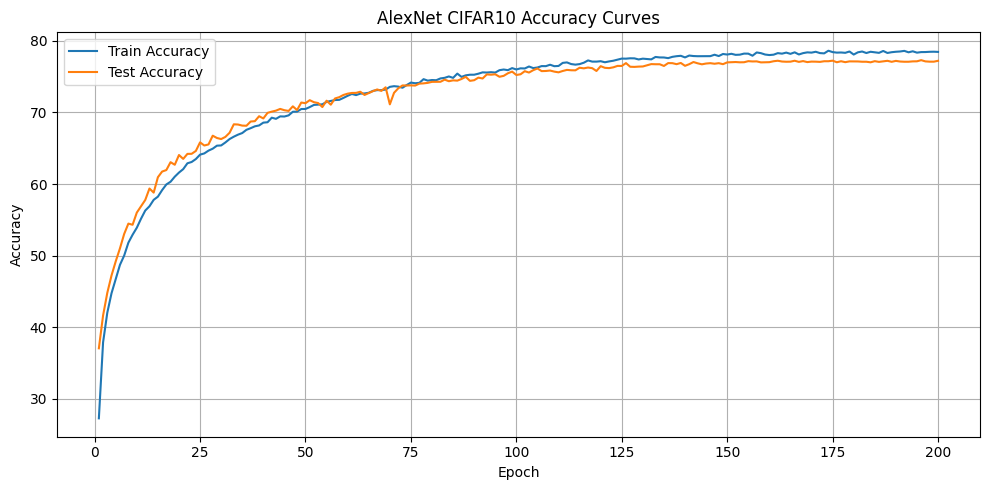

In [15]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_acc, label="Train Accuracy")
plt.plot(range(1, epochs + 1), test_acc, label="Test Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"AlexNet CIFAR10 Accuracy Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"alexnet_cifar10_normal_accuracy_curve.png")
plt.show()

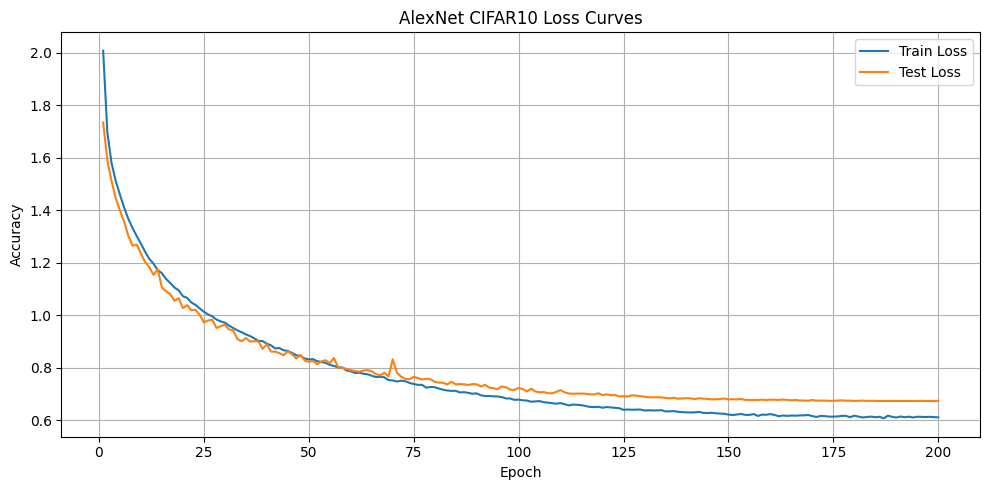

In [16]:
plt.figure(figsize=(10, 5))
plt.plot(range(1, epochs + 1), train_loss, label="Train Loss")
plt.plot(range(1, epochs + 1), test_loss, label="Test Loss")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.title(f"AlexNet CIFAR10 Loss Curves")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig(f"alexnet_cifar10_normal_loss_curve.png")
plt.show()